# Calcul de $T_1^c$ et $T_2^c$

Cells :

                              d12    d2I   dI3     d34
                          |--------|----|-------|-------|
                                 a1 |---|-----| a2
               +----------+---------+---------+---------+---------+
               |          |         |   |     |         |         |
               |    +    -|>   +  ->| + |  +  |->  +   -|>   +    |
               |    im2   |    im1  | 1c|  2c |    ip1  |    ip2  |
               +----------+---------+---------+---------+---------+
                    |----------|------|    |-------|---------|
                         dx       dxc1       dxc2      dx

Dans ce module on calcule analytiquement les extrapolations de gradient en I à partir des températures en im2, im1 et 1c
Puis on fait la même chose avec 2c, ip1 et ip2

In [1]:
import sympy as sy

sy.init_printing()

## Calcul des gradients $\nabla T_g^I$ et $\nabla T_d^I$

Calcul à gauche

grad Tgi :


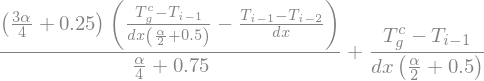

In [2]:
a1, Tim2, Tim1, Tgc, dx = sy.symbols("alpha T_{i-2} T_{i-1} T_g^c dx")

axc1 = 1 / 2 + a1 / 2
a12 = 1 / 2 + axc1 / 2
a2I = 1 + a1 - a12

dxc1 = axc1 * dx
d12 = a12 * dx
d2I = a2I * dx

gradT1 = (Tim1 - Tim2) / dx
gradT2 = (Tgc - Tim1) / dxc1

# On extrapole à l'ordre 1 le gradient à l'interface
gradTgI = gradT2 + (gradT2 - gradT1) / d12 * d2I
print("grad Tgi :")
gradTgI

Calcul à droite

grad Tdi :


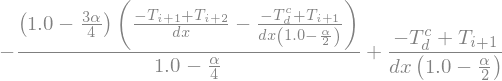

In [3]:
Tip2, Tip1, Tdc = sy.symbols("T_{i+2} T_{i+1} T_d^c")

a2 = 1 - a1
axc2 = 1 / 2 + a2 / 2
a34 = 1 / 2 + axc2 / 2
aI3 = 1 + a2 - a34

dxc2 = axc2 * dx
dI3 = aI3 * dx
d34 = a34 * dx

gradT3 = (Tip1 - Tdc) / dxc2
gradT4 = (Tip2 - Tip1) / dx

# On extrapole à l'ordre 1 le gradient à l'interface
gradTdI = gradT3 - (gradT4 - gradT3) / d34 * dI3
print("grad Tdi :")
gradTdI

## Définition du système d'équation

Tdc :


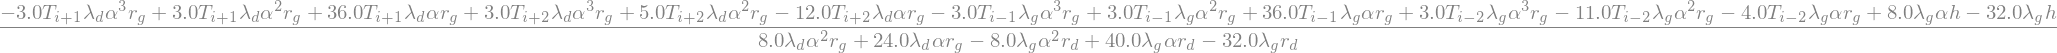

In [4]:
# Égalité des flux à l'interface
ldag, ldad = sy.symbols("\lambda_g \lambda_d")
eq1 = sy.Eq(ldag * gradTgI, ldad * gradTdI)

# Énergie dans la cellule
rhocpg, rhocpd, h = sy.symbols("r_g r_d h")
eq2 = sy.Eq(a1 * rhocpg * Tgc + a2 * rhocpd * Tdc, h)

# Résolution du système :
sol = sy.solve([eq1, eq2], [Tgc, Tdc])
print("Tdc :")
sy.simplify(sol[Tdc])

Tgc :


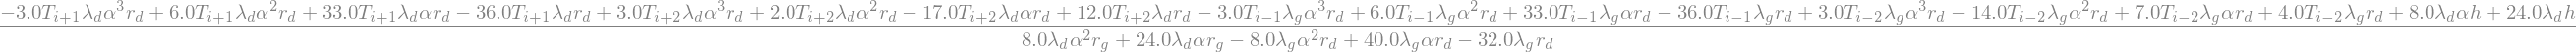

In [5]:
print("Tgc :")
sy.simplify(sol[Tgc])

alpha interdit :


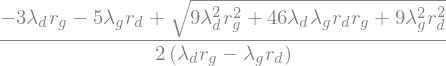

In [6]:
eq3 = (
    8 * a1**2 * ldad * rhocpg
    - 8 * a1**2 * ldag * rhocpd
    + 24 * a1 * ldad * rhocpg
    + 40 * a1 * ldag * rhocpd
    - 32 * ldag * rhocpd
)

aint = sy.solve(eq3, a1)
print("alpha interdit :")
aint[0]

# Calcul de T1 et T2 en utilisant deux équations d'évolution

On utilise une équation d'évolution sur la température et une sur l'énergie.
On en déduit $T_g^c$ et $T_d^c$.

On calcule $T_I$ avec égalité des gradients à l'ordre 2.

Tgc : 


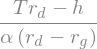

In [7]:
T = sy.symbols("T")
eq1 = sy.Eq(rhocpg * a1 * Tgc + rhocpd * a2 * Tdc, h)
eq2 = sy.Eq(a1 * Tgc + a2 * Tdc, T)

sol1 = sy.solve([eq1, eq2], [Tgc, Tdc])
print("Tgc : ")
sy.simplify(sol1[Tgc])

Tdc : 


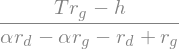

In [8]:
print("Tdc : ")
sy.simplify(sol1[Tdc])

# Calcul Tg et Td avec cellules décalées

Cells :

                                                  I
                                          ag |---|-----| ad
               +---------+---------+---------+---------+---------+---------+---------+
               |         |         |         |   |     |         |         |         |
               |    +   -|    +   -|>   +    |   |+    |    +   -|>   +    |>   +    |
               |    im3  |    im2  |    im1  |   |i    |    ip1  |    ip2  |    ip3  |
               +---------+---------+---------+---------+---------+---------+---------+
                   |         |         |         |         |         |         |   
                   |    +    |    +    |    +    |    +    |    +    |    +    |   
                   |    jm2  |    jm1  |    j    |    jp1  |    jp2  |    jp3  |   
                   +---------+---------+---------+---------+---------+---------+
                              

Dans ce module on calcule analytiquement les extrapolations de gradient en I à partir des températures en im2, im1 et 1c
Puis on fait la même chose avec 2c, ip1 et ip2

On a :

- $i-1 < j < i$ ce qui nous donne qu'on peut interpoler de i à j aux bords (pour jm2, jm1 et jp2, jp3 par ex) en utilisant les valeurs en i (et donc cans ce cas im3, im2, im1 et ip1, ip2, ip3)
- $j < i < j+1$ ce qui nous donne qu'on peut interpoler de j à i à proximité de l'interface, donc pour im1, i et ip1

Dans ce cas là, la formulation ne sera pas complètement conservative car ce sont les températures que l'on corrige et non les flux.

Mais cela me semble être la meilleure possibilité pour se passer des difficultés liées à la convection.

Résumé des étapes :

1. interpolation de $T_i$ à $T_j$ pour $i_0 - 3 \leq i \leq i_0+3$ et $i_0-2 \leq j \leq i_0+3$
2. équation d'évolution sur les $T_j$ pour $i-1 \leq j \leq i+1$
3. nouvelle interpolation sur $T_i$
